In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

import datetime
import os
import shutil

#matplotlib.rcParams['agg.path.chunksize'] = 1000


In [2]:
#output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
output_path = "/home/mbille/Desktop"  # cluster_BONN

data1 = ""
#data2 = "/data_230406_150035_TtargetSearch_Re300.0_nsteps710140"

periodic_start=0.5

In [3]:
drag_1 = np.loadtxt(str(output_path+data1+"/testRe3900_drag_coefficient.txt"))
#drag_2 = np.loadtxt(str(output_path+data2+"/drag_coefficient.txt"))
#drag_diff = drag_1-drag_2  # only applicable for same resolution => same step-number

print("drag_1.mean: ", drag_1[int(drag_1.shape[0]*periodic_start-1):,2].mean())
#print("drag_2.mean: ", drag_2[int(drag_2.shape[0]*periodic_start-1):,2].mean())
#print("drag_mean_diff", drag_1[int(drag_1.shape[0]*periodic_start-1):,2].mean() - drag_2[int(drag_2.shape[0]*0.8-1):,2].mean())
print("from t >", round(drag_1[int(drag_1.shape[0]*periodic_start-1),1],2))

drag_1.mean:  1.1650111204009947
from t > 100.0


1.1485030222961736


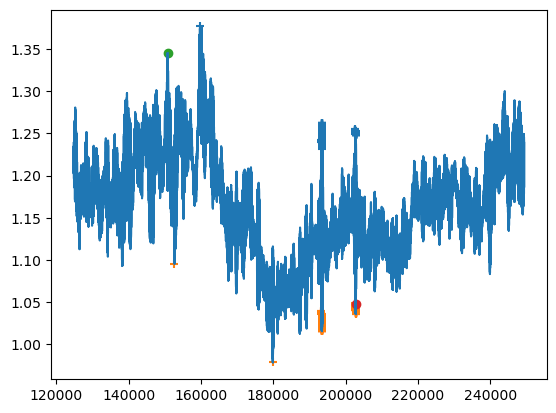

In [4]:
# FIND PEAKS and calc mean drag:

drag_1_stepsLU = drag_1[int(drag_1.shape[0]*periodic_start-1):,0]
drag_1_values = drag_1[int(drag_1.shape[0]*periodic_start-1):,2]

peaks_max = find_peaks(drag_1_values, prominence=((drag_1_values.max()-drag_1_values.min())/2))
peak_max_y = drag_1_values[peaks_max[0]]
peak_max_x = drag_1_stepsLU[peaks_max[0]]

peaks_min = find_peaks(-drag_1_values, prominence=((drag_1_values.max()-drag_1_values.min())/2))
peak_min_y = drag_1_values[peaks_min[0]]
peak_min_x = drag_1_stepsLU[peaks_min[0]]

if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
    peak_number = peaks_max[0].shape[0]
else:
    peak_number = peaks_min[0].shape[0]

if peaks_min[0][0] < peaks_max[0][0]:
    first_peak = peaks_min[0][0]
    last_peak = peaks_max[0][peak_number-1]
else:
    first_peak = peaks_max[0][0]
    last_peak = peaks_min[0][peak_number-1]

plt.plot(drag_1_stepsLU, drag_1_values)
plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number],marker="+")
plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number],marker="+")
plt.scatter(drag_1_stepsLU[first_peak],drag_1_values[first_peak],marker="o")
plt.scatter(drag_1_stepsLU[last_peak],drag_1_values[last_peak],marker="o")

drag_mean = drag_1_values[first_peak:last_peak].mean()
print(drag_mean)

In [5]:
drag_1[-1,1]
len(drag_1[:,1])

249416

In [6]:
### IDEE
# - FFT Funktion, die für eine Datenreihe das Spektrum als [freqs, Xamp] zurückgibt
# - drag, drag_reduced und drag_rolling_mean mal im Sprketrum gegeneinander plotten.

In [7]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
# die ersten n-1 Werte "fehlen"

In [8]:
n = 100
drag_rolling_mean = moving_average(drag_1[:,2], n)
drag_rolling_mean_time = drag_1[n-1:,1]

time_interval: 124.708
steps_interval: 124


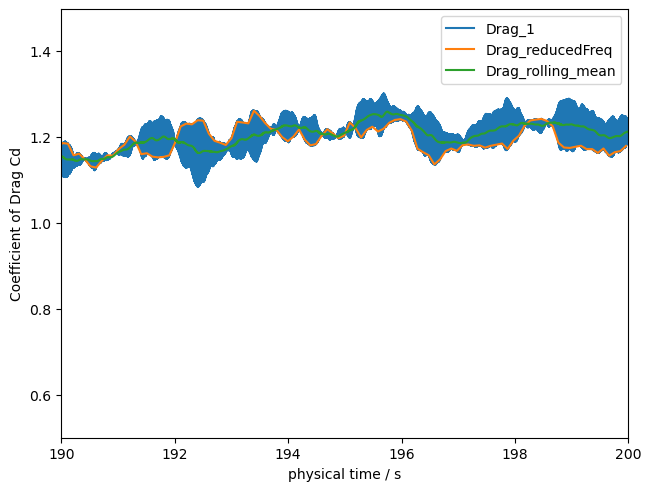

In [9]:
# PLOT DRAG

points = 2000
print("time_interval:", len(drag_1[:,1])/points)
interval = int(drag_1[-1,0]/points)
print("steps_interval:", interval)

drag_small = []

for i in range(drag_1.shape[0]):
    if i % interval == 0:
        drag_small.append(drag_1[i])
drag_small = np.array(drag_small)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_1[:,1],drag_1[:,2], drag_small[:,1], drag_small[:,2], drag_rolling_mean_time, drag_rolling_mean)
#ax.plot(drag_2[:,1],drag_2[:,2])
#ax.plot(drag_1[:,1],drag_diff[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
#ax.set_ylim([1,3])
ax.set_ylim([0.5,1.496])
#print(drag_diff[:,2].mean())
ax.set_xlim([190,200])
plt.legend(labels=["Drag_1", "Drag_reducedFreq", "Drag_rolling_mean"])
#plt.title("")

Frequency Peak: 0.0 +- 0.008333288215432468 Hz
T: 120.00064970129003
df: 0.008333288215432468
min.f: 0.008333288215432468
max.f: 623.5382907197345


(0.0, 1.0)

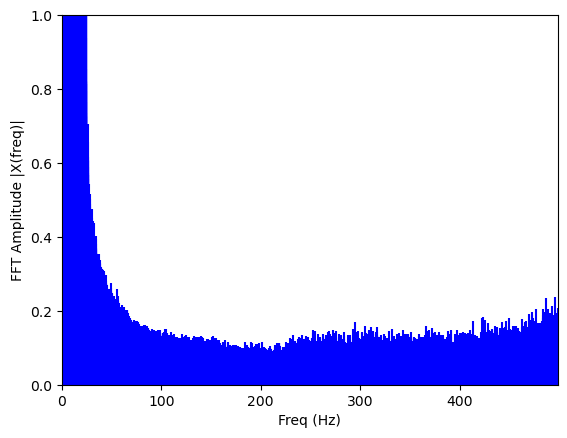

In [20]:

### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.
drag_converged = drag_1[int(0.4*drag_1.shape[0]):,:]

X = np.fft.fft(drag_converged[:, 2])  # fft result (amplitudes)
N = len(X)  # number of freqs
n = np.arange(N)  # freq index
T = N*(drag_converged[2,1]-drag_converged[1,1]) # total time measured (T_PU)
freq = n / T  # frequencies (x-axis of spectrum)

plt.figure
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")  # plot spectrum |X|(f)
plt.xlabel("Freq (Hz)")
plt.ylabel("FFT Amplitude |X(freq)|")
#plt.xlim(0,50)
# print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
plt.ylim(0, np.abs(X[10:int(X.shape[0] * 0.5)]).max())  # ylim, where highes peak is on left half of full spectrum

freq_res = freq[1] - freq[0]  # frequency-resolution
X_abs = np.abs(X[10:int(X.shape[0] * 0.4)])  # get |X| Amplitude for left half of full spectrum
freq_peak = freq[np.argmax(X_abs)]  # find frequency with highest amplitude
print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
# f = Strouhal for St=f*D/U and D=U=1 in PU

print("T:", T)
print("df:", freq_res)
print("min.f:", 1/T)
print("max.f:", 1/(drag_converged[2,1]-drag_converged[1,1])*0.5)
plt.xlim(0,1/(drag_converged[2,1]-drag_converged[1,1])*0.4)
plt.ylim(0,1)

In [19]:
lift_1 = np.loadtxt(str(output_path+data1+"/lift_coefficient.txt"))
#lift_2 = np.loadtxt(str(output_path+data2+"/lift_coefficient.txt"))
#lift_diff = lift_1-lift_2

print("Cl1_peaks: \nmin", lift_1[:,2].min(),"\nmax", lift_1[:,2].max())
#print("\nCl2_peaks: \nmin", lift_2[:,2].min(),"\nmax", lift_2[:,2].max())

Cl1_peaks: 
min -2.1996998097625324 
max 2.217708491654612


(-3.0, 3.0)

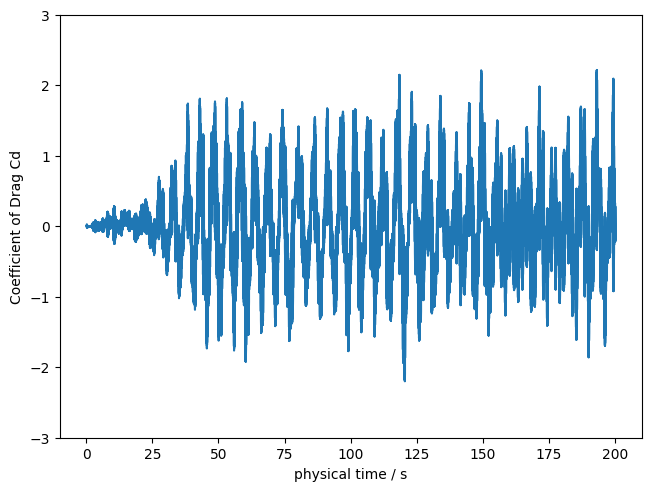

In [20]:
# PLOT LIFT

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_1[:,1],lift_1[:,2])
#ax.plot(lift_2[:,1],lift_2[:,2])
#ax.plot(lift_1[:,1],lift_diff[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([-3,3])
#ax.set_ylim([-0.01,0.01])
#ax.set_xlim([80,140])
#plt.legend(labels=["-", "-"])

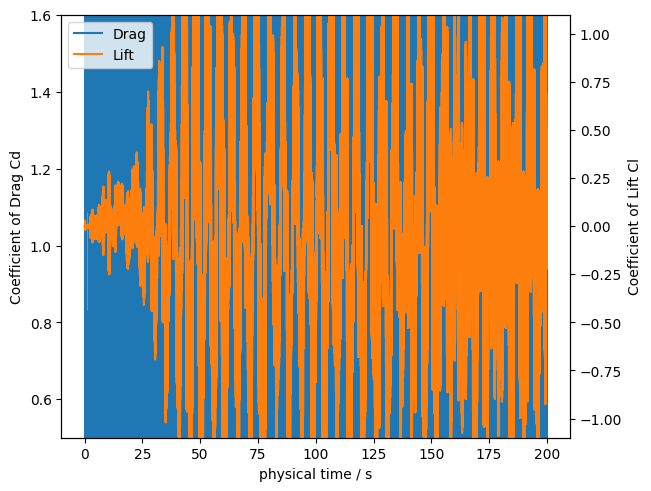

In [28]:
fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_1[:,1],drag_1[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

#secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
#secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_1[:,1],lift_1[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

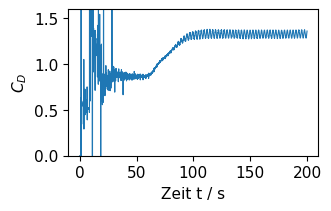

In [11]:
# Re200, GPD50, DPY50
drag = np.loadtxt("/home/mbille/Desktop/drag_coefficient.txt")
lift = np.loadtxt("/home/mbille/Desktop/lift_coefficient.txt")

matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams.update({'lines.linewidth': 0.8})
matplotlib.rcParams.update({'figure.figsize': [3.2,2]})

fig, ax = plt.subplots(constrained_layout=True, )
ax.plot(drag[:,1],drag[:,2])
ax.set_xlabel("Zeit t / s")
ax.set_ylabel("$C_{D}$")
ax.set_ylim([0,1.6])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
#secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
#secax.set_xlabel("timesteps (simulation time / LU)")
plt.show()

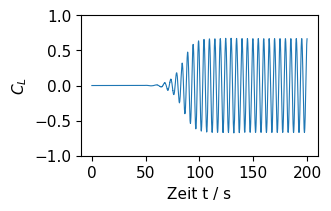

In [13]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift[:,1],lift[:,2])
ax.set_xlabel("Zeit t / s")
ax.set_ylabel("$C_{L}$")
ax.set_ylim([-1,1])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
#secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
#secax.set_xlabel("timesteps (simulation time / LU)")
plt.show()

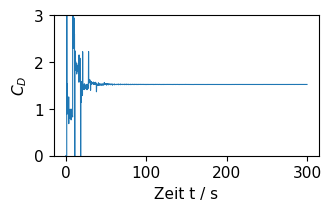

In [15]:
# Re40, GPD50, DPY50
drag = np.loadtxt("/home/mbille/Desktop/drag_coefficient_40.txt")
#lift = np.loadtxt("/home/mbille/Desktop/lift_coefficient.txt")

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag[:,1],drag[:,2])
ax.set_xlabel("Zeit t / s")
ax.set_ylabel("$C_{D}$")
ax.set_ylim([0,3])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
#secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
#secax.set_xlabel("timesteps (simulation time / LU)")
plt.show()